# PARTICLE Flow Network Classification  

In [3]:
import uproot as ur
import awkward as ak
import numpy as np

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

## Read dataset trees for pi0 and pipm

Inputs consists of two components:
- `X` : has X_pipm first and then X_pi0. It has shape `(num_clusters,max_num_cells,4)`  The cells are given as `(log(E),eta,phi,samplerID)` values
- `Y` : a numpy array of quark/gluon jet labels (pipm=`1` and pi0=`0`). 

In [6]:
# my worspace and directories
path_prefix = '/home/dportill/LCStudies/'
plotpath = path_prefix+'classifier/Plots_EFN/'
modelpath = path_prefix+'classifier/Models_EFN/'

data_path = '/fast_scratch/atlas_images/v01-45/'

In [7]:
X = np.load(data_path+'X_4.npy')

In [8]:
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(90000), np.zeros(90000))))

* Phi_sizes : The sizes of the dense layers in the per-particle frontend module $\Phi$. The last element will be the number of latent observables that the model defines. Larger latent space dimensions correspond roughly to higher resolution images.
* F_sizes : The sizes of the dense layers in the backend module $F$.

## Default Phi_sizes, F_sizes and latent space dimensions

In [9]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [10]:
from energyflow.utils import data_split

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)

* ### EarlyStopping

        - **patience**=`None` : _int_
            - The number of epochs with no improvement after which the training
            is stopped (using the [EarlyStopping](https://keras.io/
            callbacks/#earlystopping) callback). If `None` then no early stopping
            is used.
        - **earlystop_opts**=`{'restore_best_weights':True, 'verbose':1}` : _dict_
            - Dictionary of keyword arguments to be passed on to the
            [`EarlyStopping`](https://keras.io/callbacks/#earlystopping)
            callback, if it is present. `patience` (see above) is included in
            this dictionary. All other arguments are the Keras defaults.
            
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False)

* loss

In [15]:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [16]:
pfn_v0 = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

The Keras Masking layer is used to ignore all-zero particles
during the training and evaluation of the network. The Keras TimeDistributed layer
is used to apply the function Φ to each particle, which in the relevant language is a
“time step”. To carry out the summation in the latent space, we use the Keras Dot
layer for the EFN architecture, to product and sum the transverse momentum fractions
with the latent observables, and the Lambda layer for the PFN architecture, to sum
over the particles. 

In [17]:
# train model
history_v0 = pfn_v0.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        callbacks=[callback],
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 21s 62ms/step - loss: 4.4894 - acc: 0.7111 - val_loss: 0.6475 - val_acc: 0.7901
Epoch 2/100
260/260 [==============================] - 14s 55ms/step - loss: 0.8122 - acc: 0.7467 - val_loss: 0.5192 - val_acc: 0.7870
Epoch 3/100
260/260 [==============================] - 14s 54ms/step - loss: 0.4848 - acc: 0.7614 - val_loss: 0.4188 - val_acc: 0.7733
Epoch 4/100
260/260 [==============================] - 15s 56ms/step - loss: 0.4557 - acc: 0.7636 - val_loss: 0.4028 - val_acc: 0.7923
Epoch 5/100
260/260 [==============================] - 14s 55ms/step - loss: 0.4274 - acc: 0.7809 - val_loss: 0.3992 - val_acc: 0.8097
Epoch 6/100
260/260 [==============================] - 14s 55ms/step - loss: 0.3925 - acc: 0.8097 - val_loss: 0.3876 - val_acc: 0.8060
Epoch 7/100
260/260 [==============================] - 15s 56ms/step - loss: 0.3766 - acc: 0.8231 - val_loss: 0.3541 - val_acc: 0.8266
Epoch 8/100
260/260 [==============================] - 

In [19]:
pfn_v0.save(modelpath+'pfn_v0_Epoch35Loss.h5')

In [27]:
# get area under the ROC curve
preds = pfn_v0.predict(X_test, batch_size=1000)
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print("Epochs run: " , len(history_v0.history['loss']) )
print('AUC:', auc)

Epochs run:  35
AUC: 0.97436100224361


<Figure size 432x288 with 0 Axes>

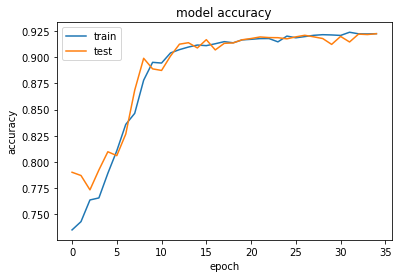

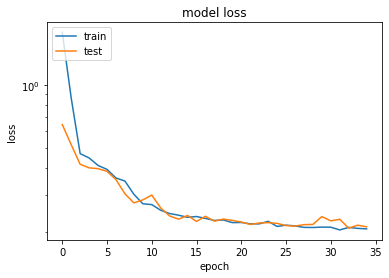

In [29]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_v0.history['acc'])
plt.plot(history_v0.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_v0.history['loss'])
plt.plot(history_v0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* val_loss

In [31]:
pfn_v0_val_loss = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
____________________________________________________________________________________________

In [32]:
# train model
history_v0_val_loss  = pfn_v0_val_loss.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 15s 55ms/step - loss: 8.6614 - acc: 0.6771 - val_loss: 0.6448 - val_acc: 0.7232
Epoch 2/100
260/260 [==============================] - 14s 54ms/step - loss: 0.7241 - acc: 0.7478 - val_loss: 0.4467 - val_acc: 0.7920
Epoch 3/100
260/260 [==============================] - 15s 57ms/step - loss: 0.5174 - acc: 0.7619 - val_loss: 0.4965 - val_acc: 0.7430
Epoch 4/100
260/260 [==============================] - 14s 53ms/step - loss: 0.5511 - acc: 0.7534 - val_loss: 0.4183 - val_acc: 0.7896
Epoch 5/100
260/260 [==============================] - 15s 56ms/step - loss: 0.4462 - acc: 0.7751 - val_loss: 0.4162 - val_acc: 0.7543
Epoch 6/100
260/260 [==============================] - 14s 53ms/step - loss: 0.4321 - acc: 0.7757 - val_loss: 0.4038 - val_acc: 0.8021
Epoch 7/100
260/260 [==============================] - 14s 54ms/step - loss: 0.4108 - acc: 0.8022 - val_loss: 0.3914 - val_acc: 0.7889
Epoch 8/100
260/260 [==============================] - 

In [33]:
pfn_v0_val_loss.save(modelpath+'pfn_v0_val_loss.h5')

In [41]:
# get area under the ROC curve
preds_v0_val_loss = pfn_v0_val_loss.predict(X_test, batch_size=1000)
auc_v0_val_loss = roc_auc_score(Y_test[:,1], preds_v0_val_loss[:,1])
print("Epochs run: " , len(history_v0_val_loss.history['loss']) )
print('AUC:', auc_v0_val_loss)

Epochs run:  26
AUC: 0.9715965347159652


<Figure size 432x288 with 0 Axes>

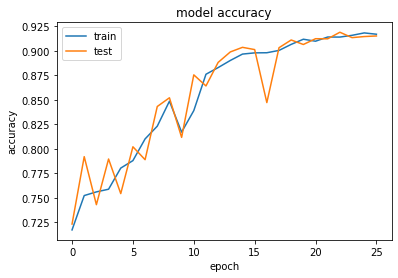

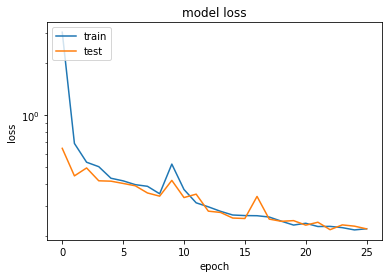

In [36]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_v0_val_loss.history['acc'])
plt.plot(history_v0_val_loss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_v0_val_loss.history['loss'])
plt.plot(history_v0_val_loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* val_acc

In [37]:
pfn_v0_val_acc = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0][0]              
____________________________________________________________________________________________

In [38]:
# train model
history_v0_val_acc  = pfn_v0_val_acc.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)],
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 15s 55ms/step - loss: 7.6097 - acc: 0.6959 - val_loss: 1.6074 - val_acc: 0.7720
Epoch 2/100
260/260 [==============================] - 14s 53ms/step - loss: 0.8198 - acc: 0.7468 - val_loss: 0.5796 - val_acc: 0.7135
Epoch 3/100
260/260 [==============================] - 14s 53ms/step - loss: 0.6301 - acc: 0.7565 - val_loss: 0.4106 - val_acc: 0.7820
Epoch 4/100
260/260 [==============================] - 14s 55ms/step - loss: 0.5348 - acc: 0.7570 - val_loss: 0.4066 - val_acc: 0.7972
Epoch 5/100
260/260 [==============================] - 14s 55ms/step - loss: 0.4156 - acc: 0.7878 - val_loss: 0.3929 - val_acc: 0.8171
Epoch 6/100
260/260 [==============================] - 14s 53ms/step - loss: 0.4237 - acc: 0.7923 - val_loss: 0.3925 - val_acc: 0.8053
Epoch 7/100
260/260 [==============================] - 14s 54ms/step - loss: 0.3861 - acc: 0.8224 - val_loss: 0.4062 - val_acc: 0.8131
Epoch 8/100
260/260 [==============================] - 

In [39]:
pfn_v0_val_loss.save(modelpath+'pfn_v0_val_acc.h5')

In [42]:
# get area under the ROC curve
preds_v0_val_acc = pfn_v0_val_acc.predict(X_test, batch_size=1000)
auc_v0_val_acc = roc_auc_score(Y_test[:,1], preds_v0_val_acc[:,1])
print("Epochs run: " , len(history_v0_val_acc.history['loss']) )
print('AUC:', auc_v0_val_acc)

Epochs run:  8
AUC: 0.9055413540554136


* Area Under the Curve ----> 100 Epochs

??? [Dint work this metric because the model was not compiled with this one](https://stackoverflow.com/questions/55153983/how-to-save-best-model-in-keras-based-on-auc-metric)

In [43]:
auc = tf.keras.metrics.AUC()  # instantiate it here to have a shorter handle

In [44]:
callback_auc = tf.keras.callbacks.EarlyStopping(monitor='val_auc',mode='max', patience=3)

In [45]:
pfn_v0_val_auc = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_28 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_28[0][0]              
____________________________________________________________________________________________

In [46]:
# train model
history_v0_val_auc  = pfn_v0_val_auc.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        callbacks= [callback_auc],
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 15s 56ms/step - loss: 6.7372 - acc: 0.6993 - val_loss: 0.5892 - val_acc: 0.7292
Epoch 2/100
260/260 [==============================] - 14s 54ms/step - loss: 0.8409 - acc: 0.7445 - val_loss: 0.4412 - val_acc: 0.7829
Epoch 3/100
260/260 [==============================] - 14s 55ms/step - loss: 0.5759 - acc: 0.7655 - val_loss: 1.4581 - val_acc: 0.5678
Epoch 4/100
260/260 [==============================] - 14s 53ms/step - loss: 0.6505 - acc: 0.7572 - val_loss: 0.4276 - val_acc: 0.7863
Epoch 5/100
260/260 [==============================] - 14s 56ms/step - loss: 0.4535 - acc: 0.7730 - val_loss: 0.4095 - val_acc: 0.7898
Epoch 6/100
260/260 [==============================] - 14s 55ms/step - loss: 0.4202 - acc: 0.7836 - val_loss: 0.3942 - val_acc: 0.8026
Epoch 7/100
260/260 [==============================] - 14s 54ms/step - loss: 0.4031 - acc: 0.7981 - val_loss: 0.3874 - val_acc: 0.8164
Epoch 8/100
260/260 [==============================] - 

In [47]:
pfn_v0_val_auc.save(modelpath+'pfn_v0_100Epochs.h5')

In [50]:
# get area under the ROC curve
preds_v0_val_auc = pfn_v0_val_auc.predict(X_test, batch_size=1000)
auc_v0_val_auc = roc_auc_score(Y_test[:,1], preds_v0_val_auc[:,1])
print("Epochs run: " , len(history_v0_val_auc.history['loss']) )
print('AUC:', auc_v0_val_auc)

Epochs run:  100
AUC: 0.9775741060257409


<Figure size 432x288 with 0 Axes>

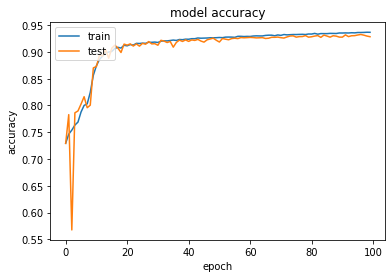

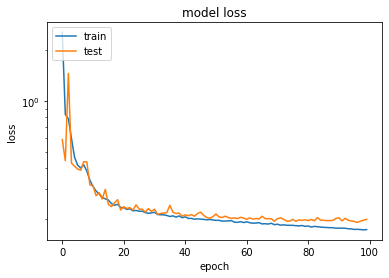

In [51]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_v0_val_auc.history['acc'])
plt.plot(history_v0_val_auc.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_v0_val_auc.history['loss'])
plt.plot(history_v0_val_auc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* 50 Epochs


In [11]:
pfn_v0_50 = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [12]:
# train model
history_v0_50  = pfn_v0_50.fit(X_train, Y_train,
        epochs=50,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/50
260/260 [==============================] - 16s 58ms/step - loss: 7.1945 - acc: 0.6985 - val_loss: 0.5708 - val_acc: 0.7858
Epoch 2/50
260/260 [==============================] - 17s 64ms/step - loss: 0.6555 - acc: 0.7492 - val_loss: 0.4804 - val_acc: 0.7765
Epoch 3/50
260/260 [==============================] - 14s 55ms/step - loss: 0.4948 - acc: 0.7614 - val_loss: 0.5283 - val_acc: 0.6730
Epoch 4/50
260/260 [==============================] - 14s 55ms/step - loss: 0.4668 - acc: 0.7631 - val_loss: 0.4557 - val_acc: 0.7166
Epoch 5/50
260/260 [==============================] - 14s 55ms/step - loss: 0.4371 - acc: 0.7749 - val_loss: 0.4077 - val_acc: 0.7980
Epoch 6/50
260/260 [==============================] - 14s 56ms/step - loss: 0.4164 - acc: 0.7903 - val_loss: 0.3829 - val_acc: 0.8082
Epoch 7/50
260/260 [==============================] - 14s 56ms/step - loss: 0.3851 - acc: 0.8222 - val_loss: 0.4675 - val_acc: 0.7591
Epoch 8/50
260/260 [==============================] - 15s 56ms

In [13]:
pfn_v0_50.save(modelpath+'pfn_v0_50_epochs_v2.h5')

In [14]:
# get area under the ROC curve
preds_v0_50 = pfn_v0_50.predict(X_test, batch_size=1000)
auc_v0_50 = roc_auc_score(Y_test[:,1], preds_v0_50[:,1])
print("Epochs run: " , len(history_v0_50.history['loss']) )
print('AUC:', auc_v0_50)

Epochs run:  50
AUC: 0.9748689534986894


<Figure size 432x288 with 0 Axes>

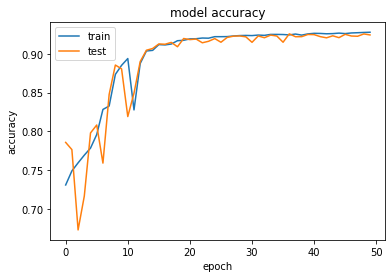

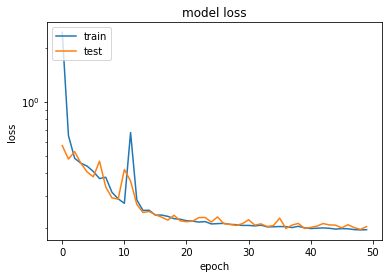

In [15]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_v0_50.history['acc'])
plt.plot(history_v0_50.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_v0_50.history['loss'])
plt.plot(history_v0_50.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

## Adding in regularization

add a penalty for weight size to the loss function.

Three different regularizer instances are provided; they are:

L1: Sum of the absolute weights.
L2: Sum of the squared weights.
L1L2: Sum of the absolute and the squared weights.

* ### latent_dropout

latent_dropout=0 : float

Dropout rates for the summation layer that defines the value of the latent observables on the inputs.

[Keras Dropout layer](https://keras.io/api/layers/regularization_layers/dropout/)
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

 dropout fractions in ML4Pions note are set to 0.2.

* latent_dropout=0.2, 50 Epochs

In [59]:
pfn_latent_dropout_02 = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, latent_dropout=0.2)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_49 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_49[0][0]              
____________________________________________________________________________________________

In [60]:
history_latent_dropout_02 = pfn_latent_dropout_02.fit(X_train, Y_train,
        epochs=50,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/50
260/260 [==============================] - 15s 56ms/step - loss: 6.4502 - acc: 0.6712 - val_loss: 0.4711 - val_acc: 0.7884
Epoch 2/50
260/260 [==============================] - 14s 54ms/step - loss: 0.5331 - acc: 0.7708 - val_loss: 0.4133 - val_acc: 0.7919
Epoch 3/50
260/260 [==============================] - 14s 54ms/step - loss: 0.4430 - acc: 0.7839 - val_loss: 0.4017 - val_acc: 0.7973
Epoch 4/50
260/260 [==============================] - 14s 54ms/step - loss: 0.4109 - acc: 0.8043 - val_loss: 0.3742 - val_acc: 0.8179
Epoch 5/50
260/260 [==============================] - 14s 54ms/step - loss: 0.3806 - acc: 0.8234 - val_loss: 0.3437 - val_acc: 0.8360
Epoch 6/50
260/260 [==============================] - 14s 54ms/step - loss: 0.3399 - acc: 0.8521 - val_loss: 0.2854 - val_acc: 0.8920
Epoch 7/50
260/260 [==============================] - 14s 54ms/step - loss: 0.2955 - acc: 0.8796 - val_loss: 0.2624 - val_acc: 0.8940
Epoch 8/50
260/260 [==============================] - 15s 56ms

In [61]:
pfn_latent_dropout_02.save(modelpath+'pfn_latent_dropout_02.h5')

In [63]:
# get area under the ROC curve
preds_latent_dropout_02 = pfn_latent_dropout_02.predict(X_test, batch_size=1000)
auc_latent_dropout_02 = roc_auc_score(Y_test[:,1], preds_latent_dropout_02[:,1])
print("Epochs run: " , len(history_latent_dropout_02.history['loss']) )
print('AUC:', auc_latent_dropout_02)

Epochs run:  50
AUC: 0.9751679597516796


<Figure size 432x288 with 0 Axes>

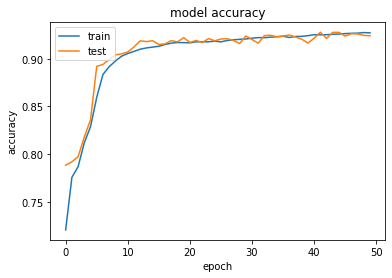

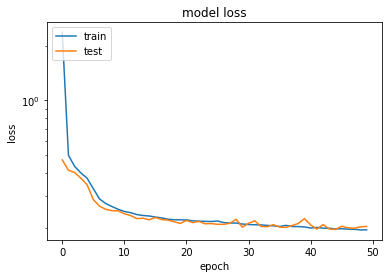

In [64]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_latent_dropout_02.history['acc'])
plt.plot(history_latent_dropout_02.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_latent_dropout_02.history['loss'])
plt.plot(history_latent_dropout_02.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* latent_dropout=0.2, 100 Epochs

In [26]:
pfn_latent_dropout_02_100Ep = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, latent_dropout=0.2)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0][0]              
____________________________________________________________________________________________

In [27]:
history_latent_dropout_02_100Ep = pfn_latent_dropout_02_100Ep.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 15s 55ms/step - loss: 7.7123 - acc: 0.6569 - val_loss: 0.4726 - val_acc: 0.7840
Epoch 2/100
260/260 [==============================] - 14s 53ms/step - loss: 0.5080 - acc: 0.7684 - val_loss: 0.4269 - val_acc: 0.7850
Epoch 3/100
260/260 [==============================] - 14s 53ms/step - loss: 0.4390 - acc: 0.7818 - val_loss: 0.4116 - val_acc: 0.7896
Epoch 4/100
260/260 [==============================] - 14s 53ms/step - loss: 0.4137 - acc: 0.8008 - val_loss: 0.3859 - val_acc: 0.8141
Epoch 5/100
260/260 [==============================] - 14s 54ms/step - loss: 0.3870 - acc: 0.8187 - val_loss: 0.3625 - val_acc: 0.8338
Epoch 6/100
260/260 [==============================] - 14s 54ms/step - loss: 0.3598 - acc: 0.8395 - val_loss: 0.3268 - val_acc: 0.8536
Epoch 7/100
260/260 [==============================] - 14s 55ms/step - loss: 0.3118 - acc: 0.8717 - val_loss: 0.2675 - val_acc: 0.8955
Epoch 8/100
260/260 [==============================] - 

In [28]:
pfn_latent_dropout_02_100Ep.save(modelpath+'pfn_latent_dropout_02_100Ep.h5')

In [29]:
# get area under the ROC curve
preds_latent_dropout_02_100Ep = pfn_latent_dropout_02_100Ep.predict(X_test, batch_size=1000)
auc_latent_dropout_02_100Ep = roc_auc_score(Y_test[:,1], preds_latent_dropout_02_100Ep[:,1])
print("Epochs run: " , len(history_latent_dropout_02_100Ep.history['loss']) )
print('AUC:', auc_latent_dropout_02_100Ep)

Epochs run:  100
AUC: 0.9785219210352193


<Figure size 432x288 with 0 Axes>

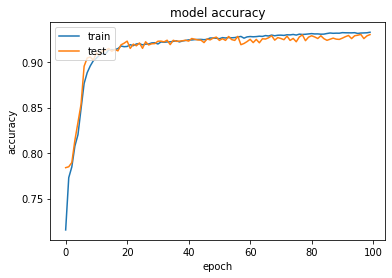

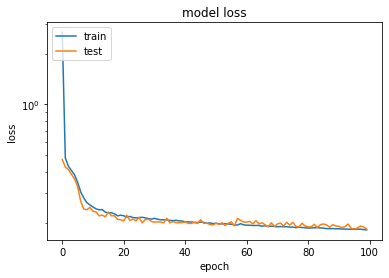

In [30]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_latent_dropout_02_100Ep.history['acc'])
plt.plot(history_latent_dropout_02_100Ep.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_latent_dropout_02_100Ep.history['loss'])
plt.plot(history_latent_dropout_02_100Ep.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* latent_dropout=0.5, 50 Epochs

In [18]:
pfn_latent_dropout_05 = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, latent_dropout=0.5)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

In [19]:
history_latent_dropout_05 = pfn_latent_dropout_05.fit(X_train, Y_train,
        epochs=50,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/50
260/260 [==============================] - 15s 55ms/step - loss: 12.8281 - acc: 0.6808 - val_loss: 0.4852 - val_acc: 0.7835
Epoch 2/50
260/260 [==============================] - 14s 53ms/step - loss: 0.5228 - acc: 0.7730 - val_loss: 0.4394 - val_acc: 0.7855
Epoch 3/50
260/260 [==============================] - 14s 53ms/step - loss: 0.4552 - acc: 0.7860 - val_loss: 0.4188 - val_acc: 0.8108
Epoch 4/50
260/260 [==============================] - 14s 53ms/step - loss: 0.4216 - acc: 0.8011 - val_loss: 0.4267 - val_acc: 0.7700
Epoch 5/50
260/260 [==============================] - 14s 53ms/step - loss: 0.3992 - acc: 0.8104 - val_loss: 0.3924 - val_acc: 0.7855
Epoch 6/50
260/260 [==============================] - 14s 53ms/step - loss: 0.3750 - acc: 0.8269 - val_loss: 0.3630 - val_acc: 0.8319
Epoch 7/50
260/260 [==============================] - 14s 53ms/step - loss: 0.3456 - acc: 0.8517 - val_loss: 0.3357 - val_acc: 0.8618
Epoch 8/50
260/260 [==============================] - 14s 54m

In [20]:
pfn_latent_dropout_05.save(modelpath+'pfn_latent_dropout_05_v2.h5')

In [21]:
# get area under the ROC curve
preds_latent_dropout_05 = pfn_latent_dropout_05.predict(X_test, batch_size=1000)
auc_latent_dropout_05 = roc_auc_score(Y_test[:,1], preds_latent_dropout_05[:,1])
print("Epochs run: " , len(history_latent_dropout_05.history['loss']) )
print('AUC:', auc_latent_dropout_05)

Epochs run:  50
AUC: 0.9695463246954632


In [22]:
##pfn_latent_dropout_05=tf.keras.models.load_model(modelpath+'pfn_latent_dropout_05.h5')

In [23]:
#predictions_latent_dropout_05 = pfn_latent_dropout_05.predict(X_test, batch_size=1000)

<Figure size 432x288 with 0 Axes>

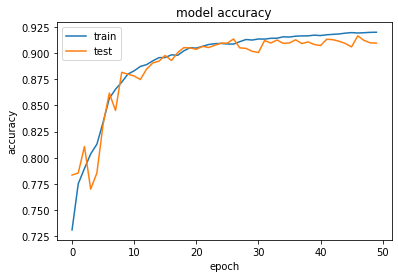

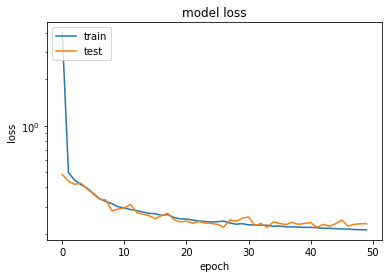

In [24]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_latent_dropout_05.history['acc'])
plt.plot(history_latent_dropout_05.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_latent_dropout_05.history['loss'])
plt.plot(history_latent_dropout_05.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* ### $L_2$ regulatization strengt

The most common type of regularization is L2, also called “weight decay,” with values often on a logarithmic scale between 0 and 0.1

L2 weight regularization with very small regularization hyperparameters such as (e.g. 0.0005) may be a good starting point.

#### Phi_l2_regs=0 : {tuple, list} of float

-$L_2$-regulatization strength for both the weights and biases of the layers in the $\Phi$ network. A single float will apply the same L2 regulatization to all layers.

* Phi_l2_regs = 0.0005

In [33]:
pfn_l2_regs0005 = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, Phi_l2_regs=0.0005)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_42 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_42[0][0]              
____________________________________________________________________________________________

In [34]:
history_l2_regs0005 = pfn_l2_regs0005.fit(X_train, Y_train,
        epochs=50,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/50
260/260 [==============================] - 15s 55ms/step - loss: 9.2040 - acc: 0.6873 - val_loss: 1.0270 - val_acc: 0.7992
Epoch 2/50
260/260 [==============================] - 14s 53ms/step - loss: 1.1746 - acc: 0.7517 - val_loss: 1.2180 - val_acc: 0.6383
Epoch 3/50
260/260 [==============================] - 14s 53ms/step - loss: 0.8075 - acc: 0.7647 - val_loss: 1.4390 - val_acc: 0.7582
Epoch 4/50
260/260 [==============================] - 14s 53ms/step - loss: 0.9145 - acc: 0.7524 - val_loss: 0.7380 - val_acc: 0.7855
Epoch 5/50
260/260 [==============================] - 14s 53ms/step - loss: 0.7061 - acc: 0.7738 - val_loss: 0.6824 - val_acc: 0.7689
Epoch 6/50
260/260 [==============================] - 14s 53ms/step - loss: 0.8107 - acc: 0.7541 - val_loss: 0.6996 - val_acc: 0.7479
Epoch 7/50
260/260 [==============================] - 14s 53ms/step - loss: 0.6768 - acc: 0.7809 - val_loss: 0.6579 - val_acc: 0.7862
Epoch 8/50
260/260 [==============================] - 14s 53ms

In [35]:
pfn_l2_regs0005.save(modelpath+'pfn_l2_regs0005.h5')

In [37]:
# get area under the ROC curve
preds_l2_regs0005= pfn_l2_regs0005.predict(X_test, batch_size=1000)
auc_l2_regs0005 = roc_auc_score(Y_test[:,1], preds_l2_regs0005[:,1])
print("Epochs run: " , len(history_l2_regs0005.history['loss']) )
print('AUC:', auc_l2_regs0005)

Epochs run:  50
AUC: 0.9717100047171001


<Figure size 432x288 with 0 Axes>

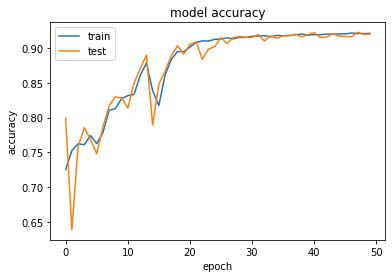

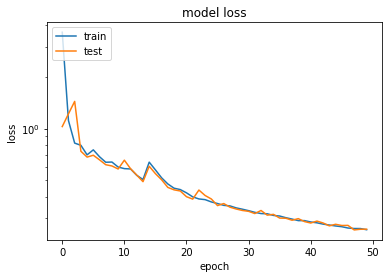

In [38]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_l2_regs0005.history['acc'])
plt.plot(history_l2_regs0005.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_l2_regs0005.history['loss'])
plt.plot(history_l2_regs0005.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* Phi_l2_regs = 0.001

In [40]:
pfn_l2_regs001 = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, Phi_l2_regs=0.001)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_56 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_56[0][0]              
____________________________________________________________________________________________

In [41]:
history_l2_regs001 = pfn_l2_regs001.fit(X_train, Y_train,
        epochs=50,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/50
260/260 [==============================] - 15s 55ms/step - loss: 6.8444 - acc: 0.6816 - val_loss: 3.2316 - val_acc: 0.7203
Epoch 2/50
260/260 [==============================] - 14s 53ms/step - loss: 1.4937 - acc: 0.7409 - val_loss: 1.0762 - val_acc: 0.7158
Epoch 3/50
260/260 [==============================] - 14s 53ms/step - loss: 1.0192 - acc: 0.7617 - val_loss: 0.9123 - val_acc: 0.7853
Epoch 4/50
260/260 [==============================] - 14s 53ms/step - loss: 0.9017 - acc: 0.7805 - val_loss: 0.8776 - val_acc: 0.7817
Epoch 5/50
260/260 [==============================] - 14s 54ms/step - loss: 0.8821 - acc: 0.7677 - val_loss: 0.8348 - val_acc: 0.7848
Epoch 6/50
260/260 [==============================] - 14s 54ms/step - loss: 0.8290 - acc: 0.7886 - val_loss: 0.8267 - val_acc: 0.7829
Epoch 7/50
260/260 [==============================] - 14s 54ms/step - loss: 0.8171 - acc: 0.7878 - val_loss: 0.7820 - val_acc: 0.8192
Epoch 8/50
260/260 [==============================] - 14s 53ms

In [42]:
pfn_l2_regs001.save(modelpath+'pfn_l2_regs001.h5')

In [43]:
# get area under the ROC curve
preds_l2_regs001= pfn_l2_regs001.predict(X_test, batch_size=1000)
auc_l2_regs001 = roc_auc_score(Y_test[:,1], preds_l2_regs001[:,1])
print("Epochs run: " , len(history_l2_regs001.history['loss']) )
print('AUC:', auc_l2_regs001)

Epochs run:  50
AUC: 0.9727258897272589


<Figure size 432x288 with 0 Axes>

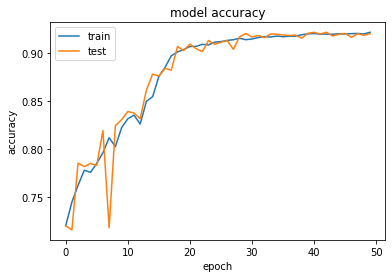

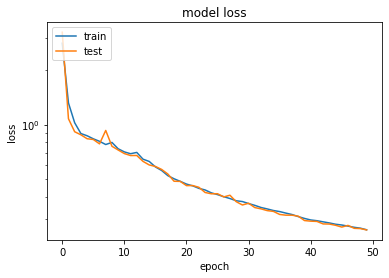

In [44]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_l2_regs001.history['acc'])
plt.plot(history_l2_regs001.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_l2_regs001.history['loss'])
plt.plot(history_l2_regs001.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* Phi_l2_regs = 0.0005 & EarlyStopping val_loss

In [46]:
pfn_l2_regs0005_val_loss = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, Phi_l2_regs=0.0005)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_70 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_70[0][0]              
___________________________________________________________________________________________

In [47]:
history_l2_regs0005_val_loss = pfn_l2_regs0005_val_loss.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 15s 55ms/step - loss: 8.5073 - acc: 0.6837 - val_loss: 0.7922 - val_acc: 0.7802
Epoch 2/100
260/260 [==============================] - 14s 53ms/step - loss: 1.0975 - acc: 0.7431 - val_loss: 0.7083 - val_acc: 0.7818
Epoch 3/100
260/260 [==============================] - 14s 53ms/step - loss: 0.7651 - acc: 0.7792 - val_loss: 0.6753 - val_acc: 0.7873
Epoch 4/100
260/260 [==============================] - 14s 53ms/step - loss: 0.6867 - acc: 0.7833 - val_loss: 0.6795 - val_acc: 0.7853
Epoch 5/100
260/260 [==============================] - 14s 53ms/step - loss: 0.6659 - acc: 0.7871 - val_loss: 0.6307 - val_acc: 0.8024
Epoch 6/100
260/260 [==============================] - 14s 53ms/step - loss: 0.6395 - acc: 0.7985 - val_loss: 0.6163 - val_acc: 0.8098
Epoch 7/100
260/260 [==============================] - 14s 53ms/step - loss: 0.6423 - acc: 0.7995 - val_loss: 0.5985 - val_acc: 0.8406
Epoch 8/100
260/260 [==============================] - 

In [48]:
pfn_l2_regs0005_val_loss.save(modelpath+'pfn_l2_regs0005_val_loss.h5')

In [49]:
# get area under the ROC curve
preds_l2_regs0005_val_loss= pfn_l2_regs0005_val_loss.predict(X_test, batch_size=1000)
auc_l2_regs0005_val_loss = roc_auc_score(Y_test[:,1], preds_l2_regs0005_val_loss[:,1])
print("Epochs run: " , len(history_l2_regs0005_val_loss.history['loss']) )
print('AUC:', auc_l2_regs0005_val_loss)

Epochs run:  59
AUC: 0.9698420609484206


<Figure size 432x288 with 0 Axes>

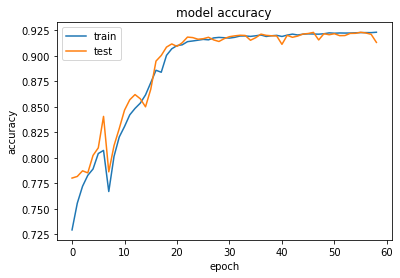

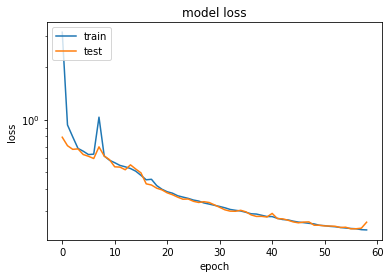

In [50]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_l2_regs0005_val_loss.history['acc'])
plt.plot(history_l2_regs0005_val_loss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_l2_regs0005_val_loss.history['loss'])
plt.plot(history_l2_regs0005_val_loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* Phi_l2_regs = 0.001 & EarlyStopping val_loss

In [51]:
pfn_l2_regs001_val_loss = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, Phi_l2_regs=0.001)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_77 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_77[0][0]              
___________________________________________________________________________________________

In [52]:
history_l2_regs001_val_loss = pfn_l2_regs001_val_loss.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 15s 55ms/step - loss: 10.5919 - acc: 0.6950 - val_loss: 1.9657 - val_acc: 0.7697
Epoch 2/100
260/260 [==============================] - 14s 53ms/step - loss: 1.8796 - acc: 0.7342 - val_loss: 1.0373 - val_acc: 0.7845
Epoch 3/100
260/260 [==============================] - 14s 53ms/step - loss: 1.0371 - acc: 0.7708 - val_loss: 0.9332 - val_acc: 0.7409
Epoch 4/100
260/260 [==============================] - 14s 53ms/step - loss: 0.9761 - acc: 0.7658 - val_loss: 1.0173 - val_acc: 0.7813
Epoch 5/100
260/260 [==============================] - 14s 54ms/step - loss: 0.9165 - acc: 0.7878 - val_loss: 0.8629 - val_acc: 0.7911
Epoch 6/100
260/260 [==============================] - 14s 54ms/step - loss: 1.0024 - acc: 0.7641 - val_loss: 0.8682 - val_acc: 0.7849
Epoch 7/100
260/260 [==============================] - 14s 54ms/step - loss: 0.8503 - acc: 0.7796 - val_loss: 0.8482 - val_acc: 0.7801
Epoch 8/100
260/260 [==============================] -

In [53]:
pfn_l2_regs001_val_loss.save(modelpath+'pfn_l2_regs001_val_loss.h5')

In [54]:
# get area under the ROC curve
preds_l2_regs001_val_loss= pfn_l2_regs001_val_loss.predict(X_test, batch_size=1000)
auc_l2_regs001_val_loss = roc_auc_score(Y_test[:,1], preds_l2_regs001_val_loss[:,1])
print("Epochs run: " , len(history_l2_regs001_val_loss.history['loss']) )
print('AUC:', auc_l2_regs001_val_loss)

Epochs run:  74
AUC: 0.9752522685025227


<Figure size 432x288 with 0 Axes>

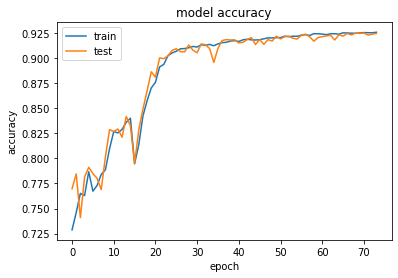

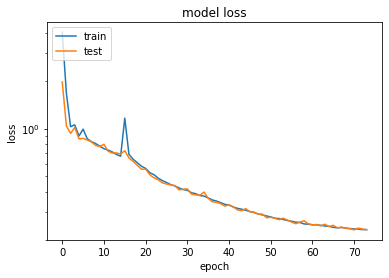

In [55]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_l2_regs001_val_loss.history['acc'])
plt.plot(history_l2_regs001_val_loss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_l2_regs001_val_loss.history['loss'])
plt.plot(history_l2_regs001_val_loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* Phi_l2_regs = 0.05 & EarlyStopping val_loss

In [56]:
pfn_l2_regs05_val_loss = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, Phi_l2_regs=0.05)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_84 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_84[0][0]              
___________________________________________________________________________________________

In [57]:
history_l2_regs05_val_loss = pfn_l2_regs05_val_loss.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 15s 55ms/step - loss: 38.3740 - acc: 0.7003 - val_loss: 20.0612 - val_acc: 0.7190
Epoch 2/100
260/260 [==============================] - 13s 52ms/step - loss: 18.4716 - acc: 0.7449 - val_loss: 14.4595 - val_acc: 0.7797
Epoch 3/100
260/260 [==============================] - 14s 53ms/step - loss: 13.5948 - acc: 0.7591 - val_loss: 11.5384 - val_acc: 0.7626
Epoch 4/100
260/260 [==============================] - 14s 53ms/step - loss: 10.9446 - acc: 0.7382 - val_loss: 9.0192 - val_acc: 0.7785
Epoch 5/100
260/260 [==============================] - 14s 53ms/step - loss: 8.6028 - acc: 0.7878 - val_loss: 7.5073 - val_acc: 0.8053
Epoch 6/100
260/260 [==============================] - 14s 53ms/step - loss: 7.2138 - acc: 0.7999 - val_loss: 6.4194 - val_acc: 0.7968
Epoch 7/100
260/260 [==============================] - 14s 53ms/step - loss: 6.2197 - acc: 0.7933 - val_loss: 5.6236 - val_acc: 0.7940
Epoch 8/100
260/260 [===========================

In [58]:
pfn_l2_regs05_val_loss.save(modelpath+'pfn_l2_regs05_val_loss.h5')

In [59]:
# get area under the ROC curve
preds_l2_regs05_val_loss= pfn_l2_regs05_val_loss.predict(X_test, batch_size=1000)
auc_l2_regs05_val_loss = roc_auc_score(Y_test[:,1], preds_l2_regs05_val_loss[:,1])
print("Epochs run: " , len(history_l2_regs05_val_loss.history['loss']) )
print('AUC:', auc_l2_regs05_val_loss)

Epochs run:  47
AUC: 0.9613157371131574


<Figure size 432x288 with 0 Axes>

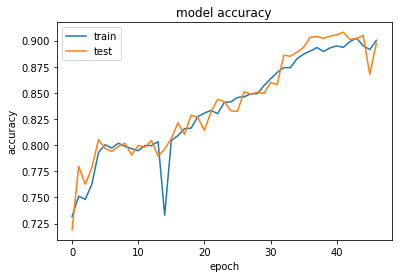

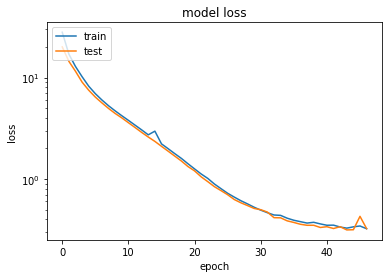

In [60]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_l2_regs05_val_loss.history['acc'])
plt.plot(history_l2_regs05_val_loss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_l2_regs05_val_loss.history['loss'])
plt.plot(history_l2_regs05_val_loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

#### F_l2_regs=0 : {tuple, list} of float

-$L_2$-regulatization strength for both the weights and biases of the layers in the $F$ network. A single float will apply the same L2 regulatization to all layers.

* F_l2_regs = 0.0005 & EarlyStopping val_loss

In [61]:
pfn_Fl2_regs0005_val_loss = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, F_l2_regs=0.0005)

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_91 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_91[0][0]              
___________________________________________________________________________________________

In [62]:
history_Fl2_regs0005_val_loss = pfn_Fl2_regs0005_val_loss.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 15s 55ms/step - loss: 9.6675 - acc: 0.6999 - val_loss: 0.7907 - val_acc: 0.7300
Epoch 2/100
260/260 [==============================] - 14s 53ms/step - loss: 0.9172 - acc: 0.7507 - val_loss: 1.1551 - val_acc: 0.7469
Epoch 3/100
260/260 [==============================] - 14s 53ms/step - loss: 0.9554 - acc: 0.7330 - val_loss: 0.5907 - val_acc: 0.7845
Epoch 4/100
260/260 [==============================] - 14s 53ms/step - loss: 0.5763 - acc: 0.7797 - val_loss: 0.5539 - val_acc: 0.7835
Epoch 5/100
260/260 [==============================] - 14s 54ms/step - loss: 0.5631 - acc: 0.7848 - val_loss: 0.5332 - val_acc: 0.7951
Epoch 6/100
260/260 [==============================] - 14s 53ms/step - loss: 0.5575 - acc: 0.7945 - val_loss: 0.5504 - val_acc: 0.7968
Epoch 7/100
260/260 [==============================] - 14s 53ms/step - loss: 0.5311 - acc: 0.7995 - val_loss: 0.5371 - val_acc: 0.7881
Epoch 8/100
260/260 [==============================] - 

In [63]:
pfn_Fl2_regs0005_val_loss.save(modelpath+'pfn_Fl2_regs0005_val_loss.h5')

In [64]:
# get area under the ROC curve
preds_Fl2_regs0005_val_loss= pfn_Fl2_regs0005_val_loss.predict(X_test, batch_size=1000)
auc_Fl2_regs0005_val_loss = roc_auc_score(Y_test[:,1], preds_Fl2_regs0005_val_loss[:,1])
print("Epochs run: " , len(history_Fl2_regs0005_val_loss.history['loss']) )
print('AUC:', auc_Fl2_regs0005_val_loss)

Epochs run:  23
AUC: 0.9700026334500264


<Figure size 432x288 with 0 Axes>

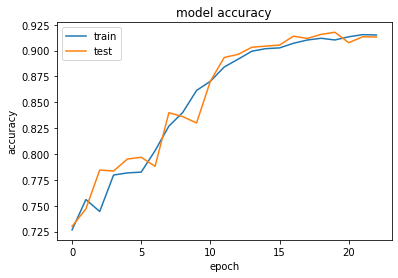

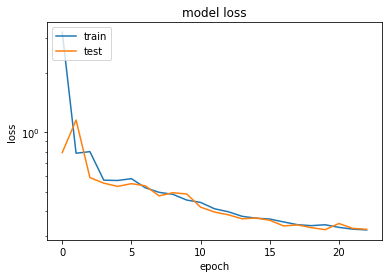

In [65]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_Fl2_regs0005_val_loss.history['acc'])
plt.plot(history_Fl2_regs0005_val_loss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_Fl2_regs0005_val_loss.history['loss'])
plt.plot(history_Fl2_regs0005_val_loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

* F_l2_regs = 0.001 & EarlyStopping val_loss

In [66]:
pfn_Fl2_regs001_val_loss = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, F_l2_regs=0.001)

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_98 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_98[0][0]              
___________________________________________________________________________________________

In [67]:
history_Fl2_regs001_val_loss = pfn_Fl2_regs001_val_loss.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 15s 55ms/step - loss: 20.2437 - acc: 0.6774 - val_loss: 1.0319 - val_acc: 0.7810
Epoch 2/100
260/260 [==============================] - 14s 53ms/step - loss: 1.3048 - acc: 0.7399 - val_loss: 0.8525 - val_acc: 0.7819
Epoch 3/100
260/260 [==============================] - 14s 52ms/step - loss: 0.9576 - acc: 0.7533 - val_loss: 0.9318 - val_acc: 0.7673
Epoch 4/100
260/260 [==============================] - 14s 52ms/step - loss: 0.9560 - acc: 0.7500 - val_loss: 0.7064 - val_acc: 0.7934
Epoch 5/100
260/260 [==============================] - 14s 54ms/step - loss: 0.7334 - acc: 0.7896 - val_loss: 0.7936 - val_acc: 0.7288
Epoch 6/100
260/260 [==============================] - 14s 53ms/step - loss: 0.7353 - acc: 0.7730 - val_loss: 0.7133 - val_acc: 0.7858
Epoch 7/100
260/260 [==============================] - 14s 53ms/step - loss: 0.7019 - acc: 0.7934 - val_loss: 0.6699 - val_acc: 0.8133
Epoch 8/100
260/260 [==============================] -

In [68]:
pfn_Fl2_regs001_val_loss.save(modelpath+'pfn_Fl2_regs001_val_loss.h5')

In [69]:
# get area under the ROC curve
preds_Fl2_regs001_val_loss= pfn_Fl2_regs001_val_loss.predict(X_test, batch_size=1000)
auc_Fl2_regs001_val_loss = roc_auc_score(Y_test[:,1], preds_Fl2_regs001_val_loss[:,1])
print("Epochs run: " , len(history_Fl2_regs001_val_loss.history['loss']) )
print('AUC:', auc_Fl2_regs001_val_loss)

Epochs run:  12
AUC: 0.9109143878591438


<Figure size 432x288 with 0 Axes>

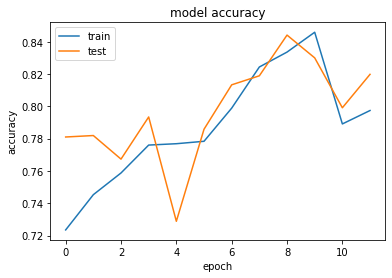

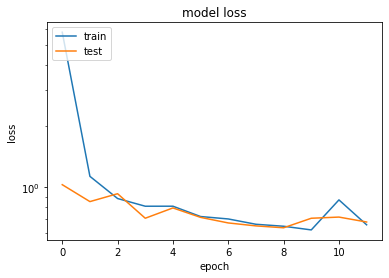

In [70]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_Fl2_regs001_val_loss.history['acc'])
plt.plot(history_Fl2_regs001_val_loss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_Fl2_regs001_val_loss.history['loss'])
plt.plot(history_Fl2_regs001_val_loss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()